# Reading In Data Files with Xarray

In order to look at CAPE and CIN trends over surface drydowns, we will need three datasets: a CAPE daily time series, CIN daily time series, and soil moisture time series.

In [1]:
import xarray as xr

To make our lives easier, we're going to do this with Python's **Xarray** package! Instructions for installing here: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [2]:
fname = "CAPE_CIN_SM.AIRS_SMAP.201503_202112.nc" # NetCDF file name
dset = xr.open_dataset(fname)

When we display the contents of our NetCDF data file, which is being stored as an Xarray **Dataset**, we see that Xarray has identified 7 **"Data variables"** with dimensions of (lat: 180, lon: 360, time:2468)

In [3]:
dset

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 2468)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2015-03-31 2015-04-01 ... 2021-12-31
Data variables:
    CAPE       (lat, lon, time) float32 ...
    CIN        (lat, lon, time) float32 ...
    SMOISTURE  (lat, lon, time) float32 ...
    ME         (lat, lon, time) float32 ...
    T_SURF     (lat, lon, time) float32 ...
    P_SURF     (lat, lon, time) float32 ...
    RH_SURF    (lat, lon, time) float32 ...
Attributes:
    description:  Daily time series of atmospheric variables from            ...

The neat thing about Xarray is that is saves the information about the time and lat/lon coordinates in the data structure itself! Furthermore, if we select a single variable using the following syntax:

In [4]:
cape = dset.CAPE
cape

<xarray.DataArray 'CAPE' (lat: 180, lon: 360, time: 2468)>
[159926400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2015-03-31 2015-04-01 ... 2021-12-31
Attributes:
    units:    J/kg

We see that this **"DataArray"** retains the coordinates. This allows us to select certain regions and time periods (e.g., months) without doing any indexing. For example, let's subset into the Western US and Eastern US using the xarray `.where()` function:

In [5]:
# defining bounds
lat1 = 30
lat2 = 50 

wus_lon1 = -130
wus_lon2 = -105

eus_lon1 = -105
eus_lon2 = -60

In [6]:
dset_wus = dset.where((dset.lat >= lat1) & (dset.lat <= lat2) & (dset.lon >= wus_lon1) & (dset.lon <= wus_lon2), drop=True)
dset_eus = dset.where((dset.lat >= lat1) & (dset.lat <= lat2) & (dset.lon >= eus_lon1) & (dset.lon <= eus_lon2), drop=True)

In both of these regions, we are only interested in CAPE during the months of June, July, August, and September (JJAS). We can select those months using xarray's `.sel()` funciton:

In [7]:
dset_wus_jja = dset_wus.sel(time=dset_wus['time.month'].isin([6,7,8]))
dset_eus_jja = dset_eus.sel(time=dset_wus['time.month'].isin([6,7,8]))

# Identifying Drydowns

Here is the function we will be using to identify drydowns in the soil moisture time series (written by Jianzhi Dong, a collaborator):

In [8]:
# You can just copy and paste all of the following code
def dry_down_scan(sm1,ts_org):
    # significant level that we think the API-based fiting error is not noise.
    # you can use sig = 0.9 or 0.95
    sig = 0.95 
    
    sm1 = np.reshape(sm1,(len(sm1),1)) 
    ts_org = np.reshape(ts_org,(len(sm1),1))
    
    # thres_range = range(sm1)/100
    thres_range = 0
    
    sm11 = sm1[0:-1]
    sm11 = sm11.T
    sm12 = sm1[1:]
    sm12 = sm12.T
    ts1 = ts_org[0:-1]
    ts1 = ts1.T
    ts2 = ts_org[1:]
    ts2 = ts2.T
    
    det_size = 1
    
    while abs(det_size) > 0:
        
        td = ts2 - ts1
        lambda1 = 0 
        lambda2 = 1
        
        L1 = len(sm12)
        
        for i in range(10):
            lam = (lambda1 + lambda2)/2
            a = sm12-np.multiply(sm11,np.power(lam,td))
            b = np.multiply(td,np.power(sm11,td-1))
            J = np.sum(np.multiply(a,b))
            if J >0:
                lambda1 =lam
            else:
                lambda2 = lam
        
        y = np.multiply(sm11,np.power(lam,td))
        err = np.std(sm12 - y)
        err_dis = sm12 - y
        thres = norm.ppf(sig,0,err)
        
        k = np.where(err_dis<thres)
        sm11 = sm11[k] 
        sm12 = sm12[k] 
        ts1 = ts1[k] 
        ts2 = ts2[k]
        
        # remove sm change smaller than the thresholds
        d = sm11 - sm12  
        t = (d - thres_range)/err*math.sqrt(len(sm11))
        k = np.where(t>=-1.75) 
        sm11 = sm11[k] 
        sm12 = sm12[k] 
        ts1 = ts1[k] 
        ts2 = ts2[k]
        
        L2 = len(sm12)
        det_size = L1 - L2
    
    y = np.multiply(sm11,np.power(lam,td))
    return [sm11,sm12,ts1,ts2]

## Example for A Single Grid Cell

Let's see how this works by applying the function to a time series for a single grid cell in the Western US:

In [9]:
# import necessary modules
import numpy as np
import math
from scipy.stats import norm

In [40]:
eus_sm = dset_eus_jja.SMOISTURE # extract the soil moisture variable, I'm going to abbreviate it as sm for laziness

# just picking a random grid cell that isn't empty
grid_i = 10
grid_j = 15
grid_sm = eus_sm[grid_i,grid_j,:]

In [41]:
grid_sm

<xarray.DataArray 'SMOISTURE' (time: 644)>
array([       nan,        nan, 0.24623296,        nan, 0.19626346,
       0.18583012,        nan, 0.40885377,        nan,        nan,
       0.3575138 ,        nan, 0.39895764, 0.41619846,        nan,
              nan,        nan,        nan, 0.39078343,        nan,
       0.41079655, 0.37337062,        nan, 0.3030966 ,        nan,
              nan,        nan,        nan, 0.40002027, 0.38824627,
              nan, 0.3559221 ,        nan,        nan, 0.2543447 ,
              nan, 0.3514301 ,        nan,        nan, 0.4104011 ,
              nan,        nan, 0.36657387,        nan, 0.34004956,
       0.2686999 ,        nan, 0.31900924,        nan,        nan,
       0.30769974,        nan, 0.24267018, 0.2205542 ,        nan,
       0.19820693,        nan,        nan, 0.23224531,        nan,
       0.20441316, 0.18873477,        nan, 0.1696282 ,        nan,
              nan, 0.15531608,        nan,        nan, 0.19484377,
              nan, 0.23695399,        nan,        nan, 0.1654934 ,
              nan, 0.17815256, 0.15137112,        nan, 0.27857244,
              nan,        nan, 0.20611429,        nan, 0.20384249,
       0.18146843,        nan, 0.18533355,        nan,        nan,
       0.14649895,        nan,        nan, 0.2941168 ,        nan,
              nan, 0.185958  ,        nan, 0.13975358, 0.12479307,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.18154985,
              nan, 0.1516707 , 0.14684677,        nan, 0.21251619,
              nan,        nan,        nan,        nan, 0.14637464,
       0.11657051,        nan, 0.10272191,        nan,        nan,
       0.40801898,        nan, 0.25985438, 0.22527936,        nan,
       0.17317304,        nan,        nan, 0.40379822,        nan,
       0.41358024,        nan,        nan, 0.39170966,        nan,
              nan, 0.21475908,        nan, 0.1694262 , 0.22065246,
              nan, 0.24122076,        nan,        nan, 0.320848  ,
              nan, 0.26737443, 0.3036679 ,        nan, 0.30002245,
              nan,        nan, 0.21616857,        nan, 0.18998921,
       0.14879265,        nan, 0.19632663,        nan,        nan,
       0.1408278 ,        nan, 0.154417  , 0.19742757,        nan,
       0.18600403,        nan,        nan, 0.13175365,        nan,
       0.11750062, 0.2468561 ,        nan, 0.19192964,        nan,
              nan, 0.26966113,        nan, 0.22792774, 0.19358325,
              nan, 0.19408408,        nan,        nan, 0.19156975,
              nan, 0.17453878, 0.22717215,        nan, 0.2533299 ,
              nan,        nan, 0.20359515,        nan], dtype=float32)
Coordinates:
    lon      float64 -89.5
    lat      float64 40.5
  * time     (time) datetime64[ns] 2015-06-01 2015-06-02 ... 2021-08-31
Attributes:
    units:    cm3/cm3

Note that there are gaps in the time series, this is normal and due to how the frequency of the SMAP satellite overpass. However, we will need to remove the nan values to use our function.

In [42]:
# first, grab the soil moisture and time series in the format we need
sm_np = grid_sm.values # using .values here because the original function was built for numpy arrays
ts = np.arange(len(grid_sm)) # number the days starting from 0, 1, 2, 3, ...

# remove the nan values
k = np.where(np.logical_not(np.isnan(sm_np))) # k is where the soil moisture time series is not nan, it's the indices we want
sm_np = sm_np[k]
ts = ts[k]

[sm1,sm2,ts1,ts2] = dry_down_scan(sm_np,ts)

In [43]:
ts1

array([  2,   4,  20,  21,  31,  44,  50,  52,  53,  58,  60,  61,  71,
        76,  79,  84,  87,  93,  96,  98, 101, 106, 107, 114, 115, 117,
       130, 131, 136, 146, 152, 157, 160, 162, 181, 185, 186, 188, 191,
       193, 194, 201, 207, 210, 212, 215, 218, 225, 226, 228, 233, 236,
       242, 257, 258, 263, 268, 273, 278, 280, 281, 288, 289, 291, 304,
       307, 312, 313, 320, 328, 329, 337, 339, 344, 350, 368, 373, 375,
       376, 384, 421, 423, 429, 431, 437, 447, 450, 455, 456, 464, 469,
       470, 475, 477, 483, 491, 493, 501, 502, 509, 512, 517, 523, 526,
       531, 533, 554, 556, 564, 565, 570, 572, 573, 583, 586, 594, 599,
       602, 604, 607, 615, 618, 621, 626, 628, 634])

In [44]:
ts2

array([  4,   5,  21,  23,  34,  45,  52,  53,  55,  60,  61,  63,  74,
        77,  82,  85,  90,  96,  98,  99, 104, 107, 109, 115, 117, 120,
       131, 133, 138, 147, 154, 160, 162, 163, 185, 186, 188, 191, 193,
       194, 196, 202, 209, 212, 215, 217, 220, 226, 228, 231, 234, 239,
       244, 258, 260, 265, 271, 274, 280, 281, 283, 289, 291, 294, 305,
       310, 313, 315, 321, 329, 331, 339, 342, 345, 352, 370, 375, 376,
       378, 386, 423, 424, 431, 432, 439, 448, 453, 456, 458, 467, 470,
       475, 477, 478, 485, 493, 494, 502, 504, 510, 515, 518, 526, 528,
       533, 534, 556, 557, 565, 567, 572, 573, 575, 586, 588, 596, 602,
       604, 605, 610, 618, 620, 623, 628, 629, 636])

How can we interpret the output? We see that `ts1` and `ts2` are both lists of indices. These correspond to days in the numbering system we created earlier (`ts`). Now comes the unintuitive part: `ts1` are all the drydown days including Day 0 (the first drydown day) up to the second-to-last day (day N-2) and `ts2` are all the drydown days in the grid cell from Day 1 to Day N-1 (second day to last day). If a drydown is longer than two days and data is available for all of those days, then those in between days will show up in both `ts1` and `ts2`.

What does that mean when we are trying to identify individual drydown "samples?" Well, if a day shows up in ts1 but not ts2, that means it's Day 0 of a drydown. If a day shows up in ts2 but not ts1, that means it's the last day of a drydown. For example, let's think about how a drydown going from ts=0 to ts=5 would show up in both time series. Also, let's say that the next drydown begins on day ts=10:
* ts1 = [0 , 1 , 2 , 3 , 4 , 10]
* ts2 = [1 , 2 , 3 , 4 , 5 , 11]

Looking carefully, we can see that the start of the first drydown (ts=0) only shows up in `ts1`. The same goes for the start of the second drydown (ts=11). Note also that, because 0 to N-2 and 1 to N-1 are the same number of days, the drydowns line up in `ts1` and `ts2`. So if the start of a drydown is element 6 (i=5) in `ts1`, then the previous element (i=4) in `ts2` is the end date of the first drydown--ts = 5.

## Saving Drydown Data

To summarize, we can:
1. Identify the first day of a drydown as a timeseries index that shows up in `ts1` but not `ts2`
2. Identify the last day of a drydown as the element in `ts2` preceding the start of the next drydown

The value of ts corresponds to the day in the timeseries of the original dataset. The element i we consider just within each timeseries array. Putting that together, we can create the following script to identify drydowns and save their CAPE data:

In [45]:
from scipy.interpolate import interp1d # in this script I interpolate the soil moisture time series to fill in the gaps

# first, extract the cape and cin for the grid cell
wus_cape = dset_wus_jja.CAPE
grid_cape = wus_cape[grid_i,grid_j,:]
wus_cin = dset_wus_jja.CIN
grid_cin = wus_cin[grid_i,grid_j,:]

# create empty numpy arrays that store the CAPE, CIN, and Soil Moisture for each drydown day in each drydown (dimensions: drydown number, drydown day)
# we're only going to be interested in storing drydowns up to day 10 for this project
max_t = 10
# to create the empty array, I'm just going to put an arbitrary number that I think is going to be more than the total number of drydown in this grid cell over our time period 
max_dd = 300 # "max drydowns"

cape_drydown = np.zeros((max_dd,max_t))*np.nan # nan is easy to work with so we're going to fill the array with nan values
cin_drydown = np.zeros((max_dd,max_t))*np.nan
sm_drydown = np.zeros((max_dd,max_t))*np.nan

dd = 0 # drydown index
if len(ts1) > 0:
    ts_day0 = ts1[0] # the first starting day is just the first element of ts1
    i = 1
    for ts in ts1[1:]: # we're going to loop through the elements of ts1, starting with the second element (i=1)
        if ts not in ts2: # this means we've reached a new starting day
            ts_end = ts2[i-1] # the end of the drydown is the element before (i-1) in the ts2 array
            n = ts_end - ts_day0 + 1 # where n is the length of the drydown
            if n <= max_t:
                cape_drydown[dd,0:n]=grid_cape[ts_day0:ts_end+1] # we add the plus one because we want to include ts_end
                cin_drydown[dd,0:n]=grid_cin[ts_day0:ts_end+1]
                # since there are gaps in the soil moisture time series, we are going to fill in and interpolate using a linear regression function
                sm_withgaps = grid_sm[ts_day0:ts_end+1]
                x_all = np.arange(0,n) # just numbering the days
                k = np.where(~np.isnan(sm_withgaps)) # picking out the days with data for training our interpolation function
                x = x_all[k]
                y = sm_withgaps[k]
                f = interp1d(x,y) # the trained interpolation function
                sm_filled = f(x_all) # we're going to apply the interpolation function to the time series with the gaps
                sm_drydown[dd,0:n]=sm_filled
            else: # if the total number of days in this drydown is great than 10 (max_t) then we're going to only save the first 10 days
                ts_cutoff = ts_day0 + max_t # in this case we cutoff here
                cape_drydown[dd,0:max_t]=grid_cape[ts_day0:ts_cutoff] # we add the plus one because we want to include ts_end
                cin_drydown[dd,0:max_t]=grid_cin[ts_day0:ts_cutoff]
                # we're going to fill in the soil moisture time series but only up to day 10 (training on the whole drydown though)
                sm_withgaps = grid_sm[ts_day0:ts_end+1]
                x_all = np.arange(0,n) # just numbering the days
                k = np.where(~np.isnan(sm_withgaps)) # picking out the days with data for training our interpolation function
                x = x_all[k]
                y = sm_withgaps[k]
                f = interp1d(x,y) # the trained interpolation function
                sm_filled = f(np.arange(0,max_t)) # we're going to apply the interpolation function to the time series with the gaps
                sm_drydown[dd,0:max_t]=sm_filled
            # now that all that's been saved, we're going to move on to the next drydown
            dd = dd+1
            ts_day0 = ts # since ts is not in ts2 we know that ts is the new day 0
        i = i+1
    # now we've reached the end of the ts arrays. at the end of the for loop, we added + 1 to i, so the true last index is i-1.
    # let's save this last drydown since we're not going to hit the beginning of the next drydown to trigger the saving from before
    ts_end = ts2[i-1] # the end of the drydown is the element before (i-1) in the ts2 array
    n = ts_end - ts_day0 + 1 # where n is the length of the drydown
    if n <= max_t:
        cape_drydown[dd,0:n]=grid_cape[ts_day0:ts_end+1] # we add the plus one because we want to include ts_end
        cin_drydown[dd,0:n]=grid_cin[ts_day0:ts_end+1]
        # since there are gaps in the soil moisture time series, we are going to fill in and interpolate using a linear regression function
        sm_withgaps = grid_sm[ts_day0:ts_end+1]
        x_all = np.arange(0,n) # just numbering the days
        k = np.where(~np.isnan(sm_withgaps)) # picking out the days with data for training our interpolation function
        x = x_all[k]
        y = sm_withgaps[k]
        f = interp1d(x,y) # the trained interpolation function
        sm_filled = f(x_all) # we're going to apply the interpolation function to the time series with the gaps
        sm_drydown[dd,0:n]=sm_filled
    else: # if the total number of days in this drydown is great than 10 (max_t) then we're going to only save the first 10 days
        ts_cutoff = ts_day0 + max_t # in this case we cutoff here
        cape_drydown[dd,0:max_t]=grid_cape[ts_day0:ts_cutoff] # we add the plus one because we want to include ts_end
        cin_drydown[dd,0:max_t]=grid_cin[ts_day0:ts_cutoff]
        # we're going to fill in the soil moisture time series but only up to day 10 (training on the whole drydown though)
        sm_withgaps = grid_sm[ts_day0:ts_end+1]
        x_all = np.arange(0,n) # just numbering the days
        k = np.where(~np.isnan(sm_withgaps)) # picking out the days with data for training our interpolation function
        x = x_all[k]
        y = sm_withgaps[k]
        f = interp1d(x,y) # the trained interpolation function
        sm_filled = f(np.arange(0,max_t)) # we're going to apply the interpolation function to the time series with the gaps
        sm_drydown[dd,0:max_t]=sm_filled

# Plotting Drydowns

In [46]:
import matplotlib.pyplot as plt

Now, we have the CAPE, CIN, and soil moisture for each drydown day, for every drydown that we identified in our grid cell. Let's see what the typical time series of each looks like!

## Averaging Across Drydowns

Whether we're looking at all the drydowns happening in a grid cell or all the drydowns happening in a region, we want to average across them to get the average day 0 CAPE, average day 1 CAPE, etc. As you'll recall, that's the first axis (axis=0) in our numpy arrays that are storing the drydown data

In [47]:
cape_average = np.nanmean(cape_drydown,axis=0)
cin_average = np.nanmean(cin_drydown,axis=0)
sm_average = np.nanmean(sm_drydown,axis=0)

Double check that the shape is the max drydown length we stored (10).

In [48]:
cape_average.shape

(10,)

## Soil Moisture Time Series

We expect soil moisture to decrease monotonically over the course of a drydown (by definition).

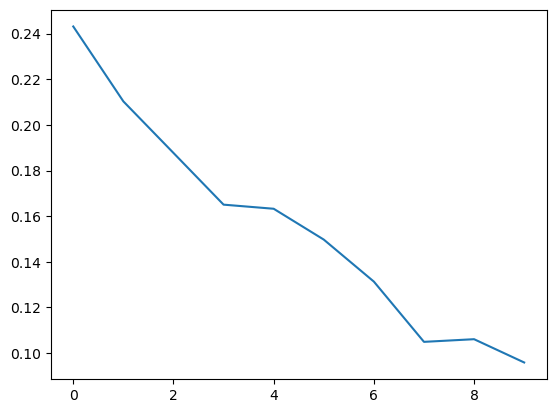

In [49]:
plt.plot(sm_average)

As expected, the soil moisture is decreasing over the course of the drydown! 

## CAPE and CIN Time Series

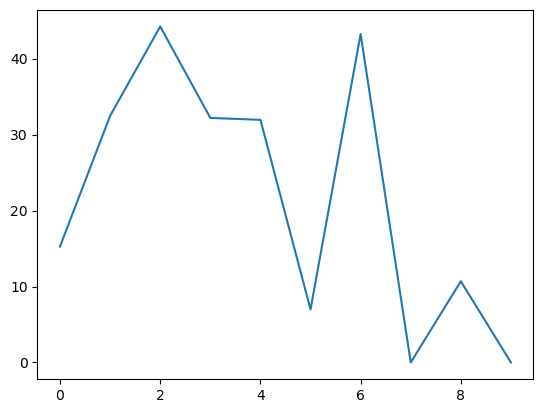

In [50]:
plt.plot(cape_average)

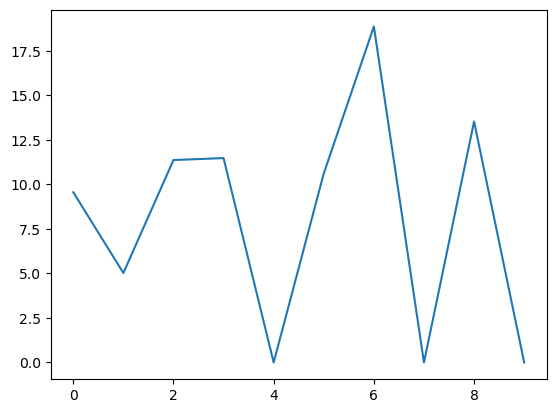

In [51]:
plt.plot(cin_average)

These look a little bit more wacky, but that's to be expected if we're only looking at one grid cell.